<a href="https://colab.research.google.com/github/nitrogenlab/GP15_watermassanalysis/blob/main/pyompa_dev2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Thermocline water masses for 10/21 meeting added.
All int and deep water mass penalties added.  
Stations 18.3 and 18.6 included. 
Parsing of BCODMO data  
Thermocline endmember files in new format  
CTD salinity flags 3 and below

In [1]:
!pip install gsw

     |████████████████████████████████| 2.4 MB 15.6 MB/s 


In [2]:
import gsw

In [3]:
!pip uninstall -y pyompa
%cd /content/
!rm -rf pyompa
!git clone https://github.com/nitrogenlab/pyompa
%cd /content/pyompa
!git checkout dev
!git log -1
!pip install .
%cd /content/

%reload_ext autoreload
%autoreload 2
from importlib import reload
import pyompa
reload(pyompa)

/content
Cloning into 'pyompa'...
remote: Enumerating objects: 1272, done.
remote: Counting objects: 100% (580/580), done.
remote: Compressing objects: 100% (384/384), done.
remote: Total 1272 (delta 410), reused 341 (delta 193), pack-reused 692
Receiving objects: 100% (1272/1272), 14.92 MiB | 20.45 MiB/s, done.
Resolving deltas: 100% (896/896), done.
/content/pyompa
Branch 'dev' set up to track remote branch 'dev' from 'origin'.
Switched to a new branch 'dev'
commit 96a9520fe0cf7ecad24b1d2ba69952d473ecfe26 (HEAD -> dev, origin/dev)
Author: Av Shrikumar <avanti.shrikumar@gmail.com>
Date:   Wed Dec 8 15:56:32 2021 -0800

    rolled back change
Processing /content/pyompa
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can f

<module 'pyompa' from '/usr/local/lib/python3.7/dist-packages/pyompa/__init__.py'>

In [4]:
%reload_ext autoreload
%autoreload 2
from importlib import reload
import pyompa
reload(pyompa)

<module 'pyompa' from '/usr/local/lib/python3.7/dist-packages/pyompa/__init__.py'>

In [5]:
#!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1Gla6o_YihOCfU5pWGLhFvL-TKm_0aXfQ' -O names_added_GP15OMPA_33RR20180918_only_gs_rosette_clean1_hy1.csv
!wget http://optserv1.whoi.edu/jgofsopt/80/128.12.123.170/GP15_Bottle_Leg1.mat -O GP15_Bottle_Leg1.mat
!wget http://optserv1.whoi.edu/jgofsopt/80/128.12.123.170/GP15_Bottle_Leg2.mat -O GP15_Bottle_Leg2.mat
#!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1Gla6o_YihOCfU5pWGLhFvL-TKm_0aXfQ' -O names_added_GP15OMPA_33RR20180918_only_gs_rosette_clean1_hy1.csv

--2021-12-12 05:13:53--  http://optserv1.whoi.edu/jgofsopt/80/128.12.123.170/GP15_Bottle_Leg1.mat
Resolving optserv1.whoi.edu (optserv1.whoi.edu)... 128.128.181.50
Connecting to optserv1.whoi.edu (optserv1.whoi.edu)|128.128.181.50|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 934504 (913K) [text/plain]
Saving to: ‘GP15_Bottle_Leg1.mat’

GP15_Bottle_Leg1.ma 100%[===================>] 912.60K   826KB/s    in 1.1s    

2021-12-12 05:13:54 (826 KB/s) - ‘GP15_Bottle_Leg1.mat’ saved [934504/934504]

--2021-12-12 05:13:55--  http://optserv1.whoi.edu/jgofsopt/80/128.12.123.170/GP15_Bottle_Leg2.mat
Resolving optserv1.whoi.edu (optserv1.whoi.edu)... 128.128.181.50
Connecting to optserv1.whoi.edu (optserv1.whoi.edu)|128.128.181.50|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1135288 (1.1M) [text/plain]
Saving to: ‘GP15_Bottle_Leg2.mat’

GP15_Bottle_Leg2.ma 100%[===================>]   1.08M  1.10MB/s    in 1.0s    

2021-12-12 05:13:56 (1.10 

In [6]:
import scipy.io
leg1 = scipy.io.loadmat('GP15_Bottle_Leg1.mat');
leg2 = scipy.io.loadmat('GP15_Bottle_Leg2.mat');
#merge data sets

In [7]:
#print list of leg1 headers
#list(leg1.keys())

In [8]:
#print list of leg2 headers
#list(leg2.keys())

In [9]:
import pandas as pd
import numpy as np
from collections import OrderedDict

header_mapping = {
    'bottle flag': ('BTLNBR_FLAG_W', 'BTLNBR_FLAG_W'),
    'CTD salinity flag': ('CTDSAL_FLAG_W', 'CTDSAL_FLAG_W'),
    #"bottle salinity flag": ('Flag_SALINITY_D_CONC_BOTTLE_tcj2lg', 'Flag_SALINITY_D_CONC_BOTTLE_zva7jm'),
    "bottle oxygen flag": ('Flag_OXYGEN_D_CONC_BOTTLE_qizf9x', 'Flag_OXYGEN_D_CONC_BOTTLE_n41f8b'),
    "silicate flag": ('Flag_SILICATE_D_CONC_BOTTLE_l9fh07','Flag_SILICATE_D_CONC_BOTTLE_3fot83'),
    "nitrate flag": ('Flag_NITRATE_D_CONC_BOTTLE_xhgtuv','Flag_NITRATE_D_CONC_BOTTLE_bugat8'),
    "phosphate flag": ('Flag_PHOSPHATE_D_CONC_BOTTLE_lof4ap','Flag_PHOSPHATE_D_CONC_BOTTLE_d0rgav'),

    "CTD pressure": ('CTDPRS','CTDPRS'),
    "CTD temperature" : ('CTDTMP','CTDTMP'),
    "practical_salinity" : ('CTDSAL','CTDSAL'), #CTD practical salinity
    "lat" : ('LATITUDE','LATITUDE'),
    "lon": ('LONGITUDE','LONGITUDE'),
    
    "stnnbr": ('STNNBR','STNNBR'),
    "geotrc_ID": ('GEOTRC_SAMPNO','GEOTRC_SAMPNO'),
    "bottom depth": ('DEPTH','DEPTH'),
    "oxygen": ('OXYGEN_D_CONC_BOTTLE_qizf9x','OXYGEN_D_CONC_BOTTLE_n41f8b'),
    "silicate": ('SILICATE_D_CONC_BOTTLE_l9fh07','SILICATE_D_CONC_BOTTLE_3fot83'),
    "nitrate": ('NITRATE_D_CONC_BOTTLE_xhgtuv','NITRATE_D_CONC_BOTTLE_bugat8'),
    'phosphate': ('PHOSPHATE_D_CONC_BOTTLE_lof4ap', 'PHOSPHATE_D_CONC_BOTTLE_d0rgav')
}

dict_for_data_frame = OrderedDict()

def convert_if_string(arr, legname):
  numpy_arr = np.array(arr.squeeze())
  if  (legname == "STNNBR" or legname == "GEOTRC_SAMPNO"):
    return numpy_arr
  elif (str(numpy_arr.dtype) == "<U4" or str(numpy_arr.dtype) == "<U5" 
      or str(numpy_arr.dtype) == "<U6" or str(numpy_arr.dtype) == "<U7" 
      or str(numpy_arr.dtype) == "<U8" or str(numpy_arr.dtype) == "<U9" 
      or str(numpy_arr.dtype) == "<U11" or str(numpy_arr.dtype) == "<U12"): 
      return np.array([(float(x) if x != 'nd' else np.nan) for x in numpy_arr])
  else:
      return numpy_arr

  if (numpy_arr == "<U4" or str(numpy_arr.dtype) == "<U5" 
      or str(numpy_arr.dtype) == "<U6" or str(numpy_arr.dtype) == "<U7" 
      or str(numpy_arr.dtype) == "<U8" or str(numpy_arr.dtype) == "<U9" 
      or str(numpy_arr.dtype) == "<U11" or str(numpy_arr.dtype) == "<U12"): 
      return np.array([(float(x) if x != 'nd' else np.nan) for x in numpy_arr])
  else:
      return numpy_arr

for (new_header_name, (leg1_name, leg2_name)) in header_mapping.items():
  print(new_header_name, leg1_name, leg2_name)
  leg1_arr = convert_if_string(leg1[leg1_name], leg1_name)
  leg2_arr = convert_if_string(leg2[leg2_name], leg2_name)
  print(leg1_arr.dtype)
  if (str(leg1_arr.dtype)=='uint8' or str(leg1_arr.dtype)=='float64'):
    print("leg1 nans", np.sum(np.isnan(leg1_arr)))
    print("leg2 nans", np.sum(np.isnan(leg2_arr)))
  else:
    print('leg1 and leg2 arrays are strings.')
  dict_for_data_frame[new_header_name] = np.concatenate([leg1_arr, leg2_arr])

gp15_df = pd.DataFrame(dict_for_data_frame)

bottle flag BTLNBR_FLAG_W BTLNBR_FLAG_W
uint8
leg1 nans 0
leg2 nans 0
CTD salinity flag CTDSAL_FLAG_W CTDSAL_FLAG_W
uint8
leg1 nans 0
leg2 nans 0
bottle oxygen flag Flag_OXYGEN_D_CONC_BOTTLE_qizf9x Flag_OXYGEN_D_CONC_BOTTLE_n41f8b
uint8
leg1 nans 0
leg2 nans 0
silicate flag Flag_SILICATE_D_CONC_BOTTLE_l9fh07 Flag_SILICATE_D_CONC_BOTTLE_3fot83
uint8
leg1 nans 0
leg2 nans 0
nitrate flag Flag_NITRATE_D_CONC_BOTTLE_xhgtuv Flag_NITRATE_D_CONC_BOTTLE_bugat8
uint8
leg1 nans 0
leg2 nans 0
phosphate flag Flag_PHOSPHATE_D_CONC_BOTTLE_lof4ap Flag_PHOSPHATE_D_CONC_BOTTLE_d0rgav
uint8
leg1 nans 0
leg2 nans 0
CTD pressure CTDPRS CTDPRS
float64
leg1 nans 487
leg2 nans 492
CTD temperature CTDTMP CTDTMP
float64
leg1 nans 487
leg2 nans 492
practical_salinity CTDSAL CTDSAL
float64
leg1 nans 487
leg2 nans 492
lat LATITUDE LATITUDE
float64
leg1 nans 476
leg2 nans 484
lon LONGITUDE LONGITUDE
float64
leg1 nans 476
leg2 nans 484
stnnbr STNNBR STNNBR
<U12
leg1 and leg2 arrays are strings.
geotrc_ID GEOTRC_SAMP

In [10]:
gp15_df

bottle flag  CTD salinity flag  ...  nitrate  phosphate
0               9                  9  ...      NaN        NaN
1               9                  9  ...      NaN        NaN
2               9                  9  ...      NaN        NaN
3               9                  9  ...      NaN        NaN
4               9                  9  ...      NaN        NaN
...           ...                ...  ...      ...        ...
6115            2                  2  ...    35.30       2.44
6116            2                  2  ...    35.25       2.39
6117            2                  2  ...    35.30       2.38
6118            2                  2  ...    35.23       2.38
6119            9                  9  ...      NaN        NaN

[6120 rows x 18 columns]

In [11]:
import pandas as pd
import numpy as np
print("starting no. of rows:",len(gp15_df))
def augment_df_with_PO_NO_SiO(df):  
    #remineralization ratios
    r_PO = 155;
    r_SiO = 15
    r_NO = 9.68
    df["PO"] = df["oxygen"] + df["phosphate"]*r_PO
    df["NO"] = df["oxygen"] + df["nitrate"]*r_NO
    df["SiO"] = df["oxygen"] + df["silicate"]*r_SiO
    return df

#remove no GEOTRACES id
gp15_df_id = gp15_df[gp15_df["geotrc_ID"] != 'nd']
gp15_df_id = pd.DataFrame(gp15_df_id)
print("no. of rows with GEOTRACES id:",len(gp15_df_id))
#remove missing data
for flag_type in ["bottle flag", "CTD salinity flag", "bottle oxygen flag",
                  "silicate flag", "nitrate flag", "phosphate flag"]:
    gp15_df = gp15_df[gp15_df[flag_type] <= 8]
gp15_df = pd.DataFrame(gp15_df)
print("no. of rows with flag above 9/missing:",len(gp15_df))
#remove bad data
for flag_type in ["bottle flag", "CTD salinity flag", "bottle oxygen flag",
                  "silicate flag", "nitrate flag", "phosphate flag"]:
    gp15_df = gp15_df[gp15_df[flag_type] <= 3]
gp15_df = pd.DataFrame(gp15_df)
print("no. of rows with flag above 4:",len(gp15_df))

#create PO offset
#gp15_df["phosphate"] = gp15_df["phosphate"] - 0.2

#add PO and NO to data frame
augment_df_with_PO_NO_SiO(gp15_df)

absolute_salinity = gsw.SA_from_SP(SP=gp15_df["practical_salinity"],
                                   p=gp15_df["CTD pressure"],
                                   lon=gp15_df["lon"],
                                   lat=gp15_df["lat"])
gp15_df["absolute_salinity"] = absolute_salinity

conservative_temp = gsw.CT_from_t(SA=absolute_salinity,
                                  t=gp15_df["CTD temperature"],
                                  p=gp15_df["CTD pressure"])
gp15_df["conservative_temp"] = conservative_temp

potential_temp = gsw.pt_from_CT(SA=absolute_salinity,
                                CT=conservative_temp)
gp15_df["potential_temp"] = potential_temp

sig0 = gsw.rho(SA=absolute_salinity, CT=conservative_temp, p=0) - 1000
gp15_df["sigma0"] = sig0

z = gsw.z_from_p(p=gp15_df["CTD pressure"], lat=gp15_df["lat"])
depth = -z #https://github.com/TEOS-10/python-gsw/blob/7d6ebe8114c5d8b4a64268d36100a70e226afaf6/gsw/gibbs/conversions.py#L577
gp15_df["Depth"] = depth

spic0 = gsw.spiciness0(SA=absolute_salinity, CT=conservative_temp)
gp15_df["spiciness"] = spic0

#calculation of planetary vorticity
rho_ref = 1000.0 #reference density
Omega = 2*np.pi/86400;
f = np.mean(2*Omega*np.sin(gp15_df["lat"]*(np.pi/180.0)))
PV = -(f/rho_ref)*(np.gradient(sig0, depth))
gp15_df["PV"] = PV #potential vorticity

print("Rows:",len(gp15_df))
gp15_df = gp15_df.dropna()
print("Rows without NA values:",len(gp15_df))

#for now, filter out station numbers with decimals 
#station numbers ending in .5 already filtered out because only fish and uway samples, which should have missing bottle data
#gp15_df = gp15_df[~gp15_df["stnnbr"].isin(['18.3', '18.6'])]
#We want to keep stations 18.3 and 18.6

starting no. of rows: 6120
no. of rows with GEOTRACES id: 5778
no. of rows with flag above 9/missing: 1161
no. of rows with flag above 4: 1144
Rows: 1144
Rows without NA values: 1143


In [12]:
gp15_df["stnnbr"]

65         5
68         5
71         5
74         5
77         5
        ... 
6104    39.0
6107    39.0
6110    39.0
6113    39.0
6116    39.0
Name: stnnbr, Length: 1143, dtype: object

In [13]:
!wget https://raw.githubusercontent.com/nitrogenlab/GP15_watermassanalysis/main/GP15_intermediateanddeep_endmemberswithsubtypes.csv -O GP15_intermediateanddeep_endmemberswithsubtypes.csv

--2021-12-12 05:13:56--  https://raw.githubusercontent.com/nitrogenlab/GP15_watermassanalysis/main/GP15_intermediateanddeep_endmemberswithsubtypes.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3531 (3.4K) [text/plain]
Saving to: ‘GP15_intermediateanddeep_endmemberswithsubtypes.csv’

GP15_intermediatean 100%[===================>]   3.45K  --.-KB/s    in 0s      

2021-12-12 05:13:57 (45.3 MB/s) - ‘GP15_intermediateanddeep_endmemberswithsubtypes.csv’ saved [3531/3531]



In [14]:
import pandas
endmember_df = pandas.read_csv("GP15_intermediateanddeep_endmemberswithsubtypes.csv")

#additional_rows = pandas.DataFrame(
#    {"watermass_name": ["PSUW", "ESSW"],
#     "conservative_temp": [4.03, 12.2],
#     "absolute_salinity": [33.38, 34.86],
#     "oxygen": [174.7, 84.6],
#     "phosphate": [1.87, 3.03],
#     "silicate": [21.58, 168.87],
#     "nitrate": [25.87, 43.5]
#    }
#)
endmember_df = augment_df_with_PO_NO_SiO(endmember_df)

In [15]:
endmember_df

watermass_name  conservative_temp  ...          NO          SiO
0          AABW_0           0.071010  ...  530.483711  2139.716361
1          AAIW_0           5.041533  ...  504.551165   444.921765
2          AAIW_1           4.472455  ...  507.761423   537.974989
3         ENPCW_0          15.987925  ...  247.706356   266.799558
4         ENPCW_1           8.553011  ...  386.072166   607.429858
5          ESSW_0          10.383632  ...  350.191298   555.193812
6          ESSW_1          16.246224  ...  282.111967   281.570792
7          EqIW_0           5.457473  ...  454.434201  1125.381429
8          EqIW_1           8.739013  ...  384.103262   670.336475
9          LCDW_0           1.546655  ...  495.066697  1590.622796
10         LCDW_1           0.767133  ...  512.999277  1997.022031
11         NPIW_0           9.413380  ...  369.051200   666.450000
12         NPIW_1           7.150665  ...  414.102010   647.233491
13         NPIW_2           4.544643  ...  450.650916  1282.825343
14          PDW_0           3.738692  ...  436.038398  1773.111917
15          PDW_1           2.155105  ...  455.351845  2536.626606
16          PDW_2           1.195157  ...  495.950594  2710.790162
17         PSUW_0           6.133319  ...  440.657140   620.673835
18         PSUW_1           4.526271  ...  469.127973   929.835633
19         SPCW_0          18.615716  ...  216.681230   217.989222
20         SPCW_1           8.395903  ...  394.884730   298.526377
21         UCDW_0           2.478317  ...  498.990634  1418.613691

[22 rows x 12 columns]

In [16]:
import json

#gp15_intermediateanddeep = pd.DataFrame(gp15_df[(gp15_df["sigma0"] >= 26.6)])
!wget https://raw.githubusercontent.com/nitrogenlab/GP15_watermassanalysis/main/station_to_tc_cutoffs.json -O station_to_tc_cutoffs.json 
station_to_tcstartend = json.loads(open("station_to_tc_cutoffs.json").read())

gp15_intermediateanddeep = gp15_df[
    gp15_df.apply(lambda x: x['Depth'] > station_to_tcstartend[str(float(x['stnnbr']))]['depth_cutoffs'][1], axis=1)]

gp15_intermediateanddeep['tc'] = 0

--2021-12-12 05:14:02--  https://raw.githubusercontent.com/nitrogenlab/GP15_watermassanalysis/main/station_to_tc_cutoffs.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13448 (13K) [text/plain]
Saving to: ‘station_to_tc_cutoffs.json’

station_to_tc_cutof 100%[===================>]  13.13K  --.-KB/s    in 0s      

2021-12-12 05:14:02 (91.7 MB/s) - ‘station_to_tc_cutoffs.json’ saved [13448/13448]



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


Visualize the end-members

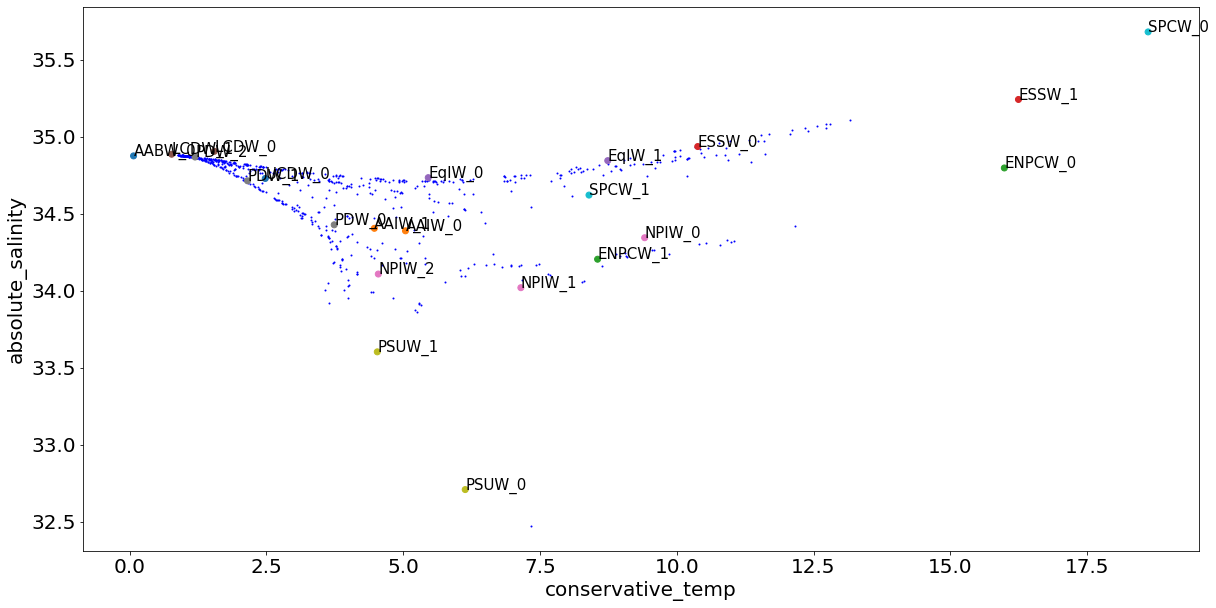

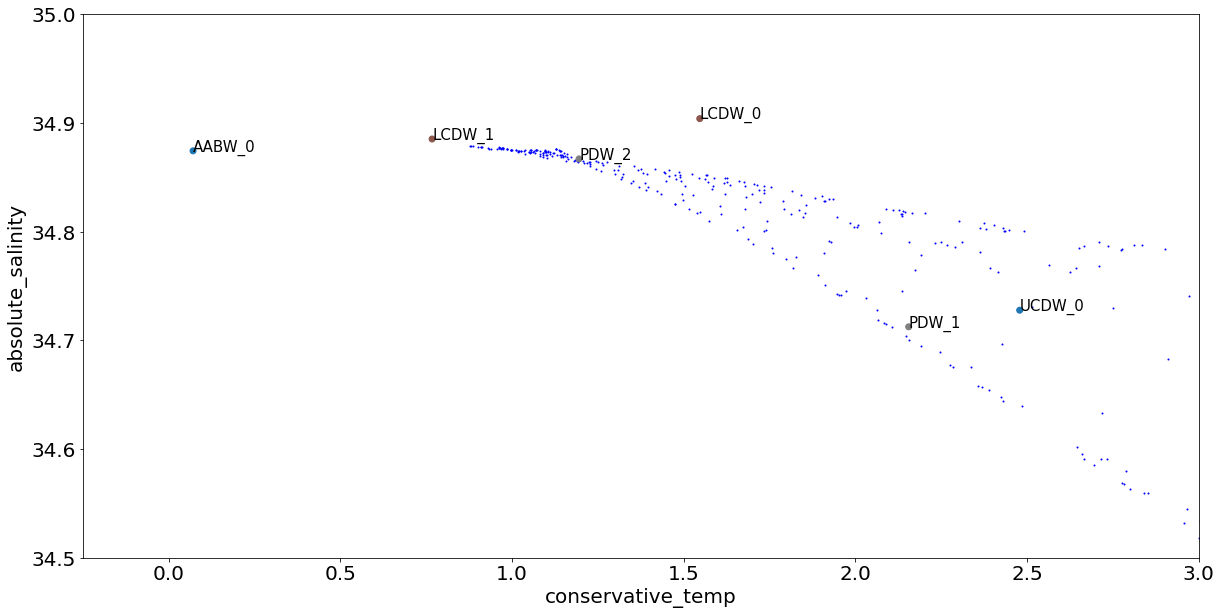

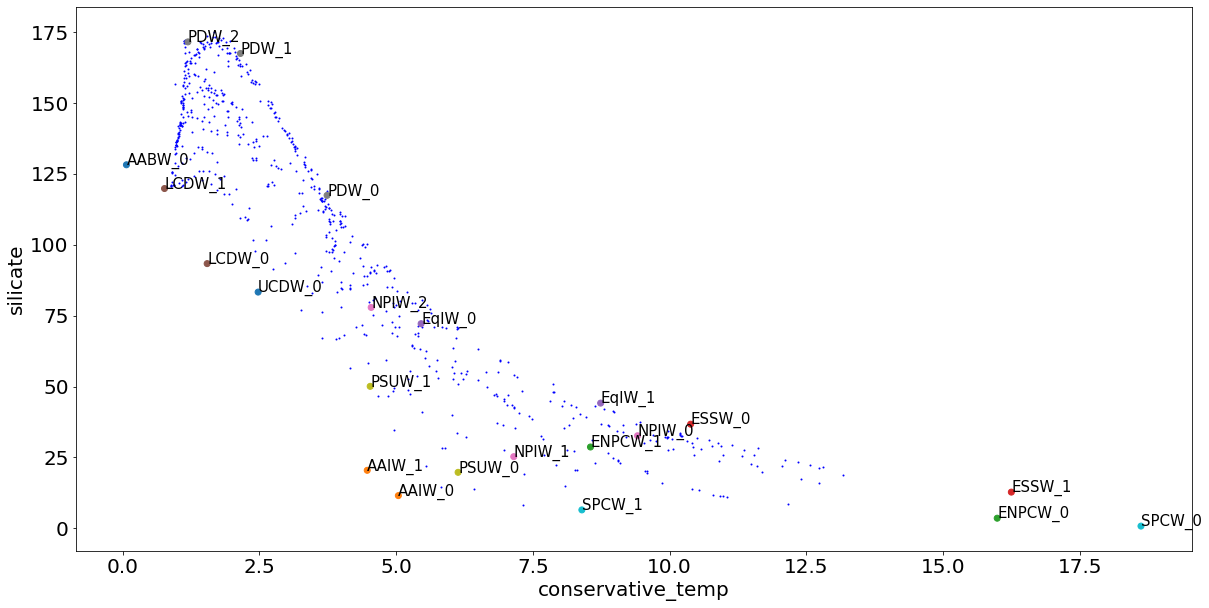

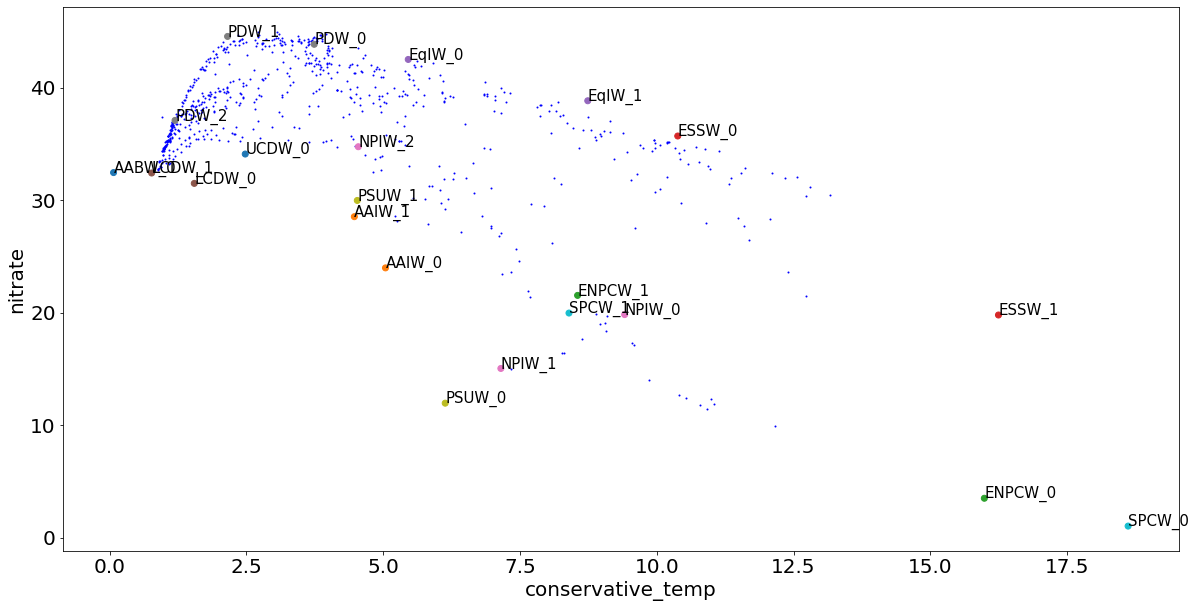

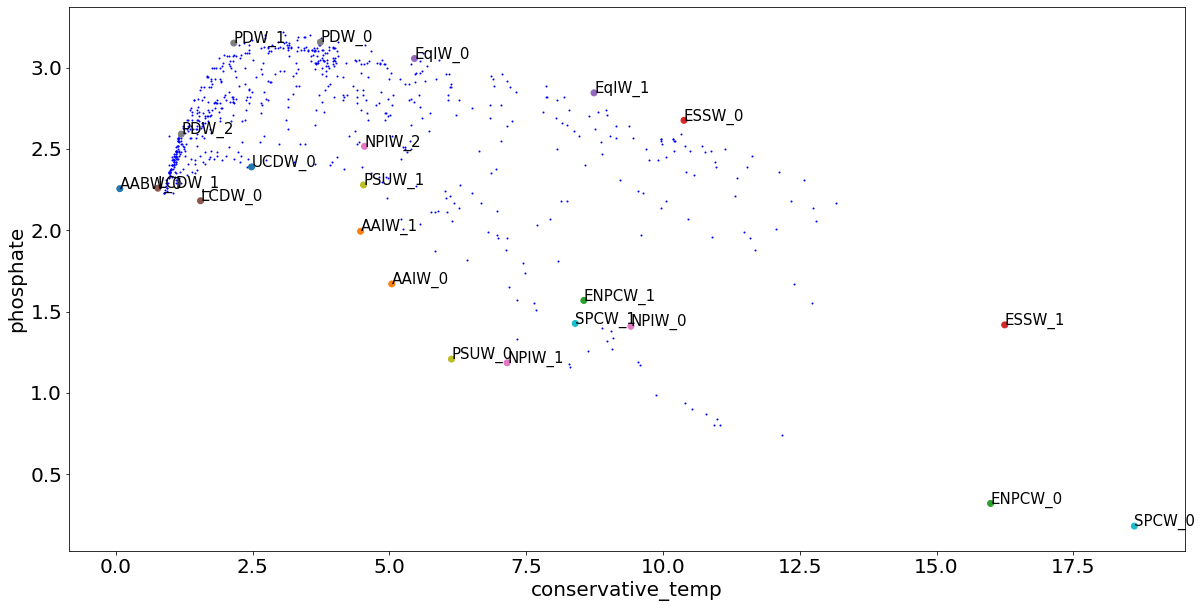

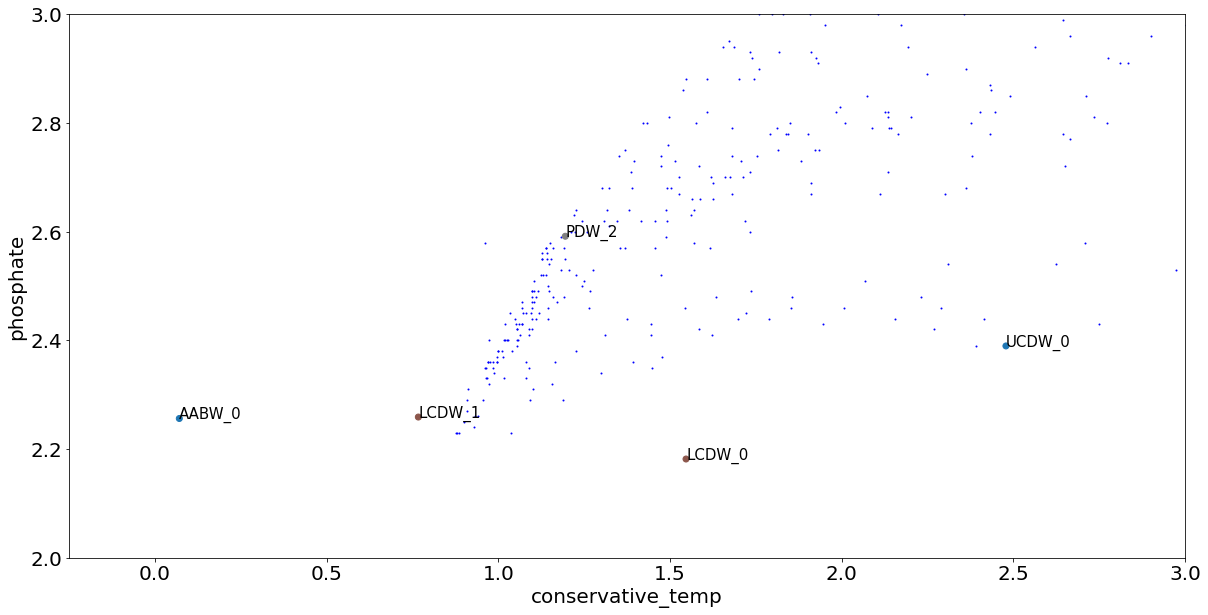

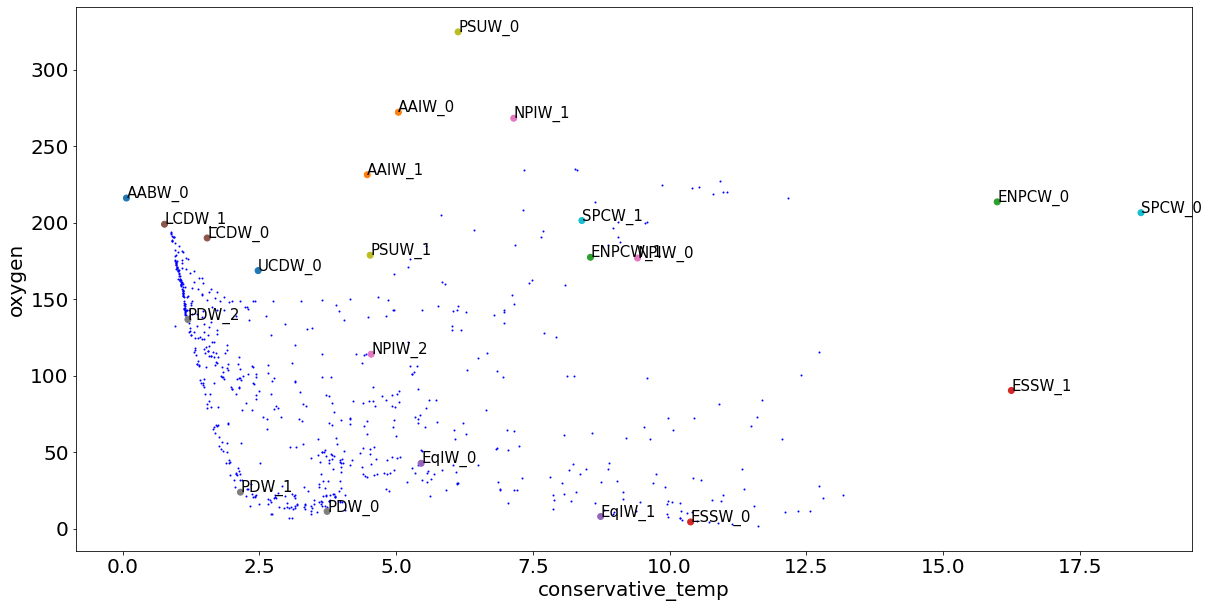

In [18]:
import matplotlib
from matplotlib import pyplot as plt
import pyompa

matplotlib.rc('axes', labelsize=20)
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20)

endmember_names = endmember_df["watermass_name"]
endmembername_to_indices = pyompa.util.get_endmember_idx_mapping(
                            endmember_names)

colors = ["C0"]*len(endmember_names)
for endmembertypeidx, endmembertype in enumerate(
      endmembername_to_indices.keys()):
  for idx in endmembername_to_indices[endmembertype]:
    colors[idx] = "C"+str(endmembertypeidx)

def make_paired_feature_plot(feature1name, feature2name, xlim=None, ylim=None):
    feature1vals = endmember_df[feature1name]
    feature2vals = endmember_df[feature2name]
    obsdf_feature1vals = gp15_intermediateanddeep[feature1name]
    obsdf_feature2vals = gp15_intermediateanddeep[feature2name]
    
    plt.figure(figsize=(20,10))
    
    ax = plt.gca()
    for i, txt in enumerate(endmember_names):
        plotme = True
        if (xlim is not None and (feature1vals[i] < xlim[0] or feature1vals[i]>xlim[1])):
            plotme = False
        if (ylim is not None and (feature2vals[i] < ylim[0] or feature2vals[i]>ylim[1])):
            plotme = False
        if (plotme):
            ax.annotate(txt, (feature1vals[i], feature2vals[i]), size=15)    
    plt.scatter(obsdf_feature1vals, obsdf_feature2vals, color="blue", s=1)
    plt.scatter(feature1vals, feature2vals, color=colors)
    plt.xlabel(feature1name)
    plt.ylabel(feature2name)
    if xlim is not None:
        plt.xlim(xlim[0], xlim[1])
    if ylim is not None:
        plt.ylim(ylim[0], ylim[1])
    plt.show()

#if you want to zoom into a region...


make_paired_feature_plot("conservative_temp", "absolute_salinity")
make_paired_feature_plot("conservative_temp", "absolute_salinity",
                         xlim=(-0.25, 3), ylim=(34.5,35))

make_paired_feature_plot("conservative_temp", "silicate")
make_paired_feature_plot("conservative_temp", "nitrate")

make_paired_feature_plot("conservative_temp", "phosphate")
make_paired_feature_plot("conservative_temp", "phosphate",
                         xlim=(-0.25, 3), ylim=(2,3))

make_paired_feature_plot("conservative_temp", "oxygen")

matplotlib.rcParams.update(matplotlib.rcParamsDefault)


In [19]:
from collections import OrderedDict

intermediateanddeep_settingtosoln = OrderedDict()

In [20]:
import pyompa
reload(pyompa)
from pyompa import OMPAProblem, EndMemExpPenaltyFunc
from collections import OrderedDict
import json


convertedparamgroups_staticremineralization = [
    pyompa.ConvertedParamGroup(
        groupname="phosphate_remin",
        conversion_ratios=[{"oxygen": -155, "phosphate": 1.0, "nitrate": 16.0}],
        always_positive=False)
]

convertedparamgroups_flexibleremineralization = [
    pyompa.ConvertedParamGroup(
        groupname="phosphate_remin",
        conversion_ratios=[#Representing C:P = 66
                           {"oxygen": -155*(66.0/106.0),
                            "phosphate": 1.0,
                            "nitrate": 16.0*(66.0/106.0)},
                           #Representing C:P = 209
                           {"oxygen": -155*(209.0/106.0),
                            "phosphate": 1.0,
                            "nitrate": 16.0*(209.0/106.0)}
                          ],
        always_positive=False)
]

rian_weighting = {
    "conservative_temp": 56.0,
    "absolute_salinity": 80.0,
    "silicate": 3.0,
    "nitrate": 5.0,
    "phosphate": 5.0,
    "oxygen": 1.0,
    "NO": 1.0,
    "PO": 0.5
}

withconversion_paramnames = ["conservative_temp", "absolute_salinity",
                             "silicate", "nitrate", "phosphate", "oxygen"]
noconversion_paramnames = ["conservative_temp", "absolute_salinity",
                           "silicate", "NO", "PO"]  

flexiblereminratio_settings = {
    "param_names": withconversion_paramnames,
    "param_weightings": rian_weighting,
    "convertedparam_groups": convertedparamgroups_flexibleremineralization}

staticreminratio_settings = {
    "param_names": withconversion_paramnames,
    "param_weightings": rian_weighting,
    "convertedparam_groups": convertedparamgroups_staticremineralization}

noremin_settings = {
    "param_names": noconversion_paramnames,
    "param_weightings": rian_weighting,
    "convertedparam_groups": []}

endmember_usagepenalty = { 
    "ENPCW_0": EndMemExpPenaltyFunc(
        spec={
            'sigma0':{'type':'density_default', 'upperbound':27},
            'lat': {'type':'other',"alpha":0.03, "beta":50, 'lowerbound':0}
            }),
    "ENPCW_1": EndMemExpPenaltyFunc(
        spec={
            'sigma0':{'type':'density_default', 'upperbound':27},
            'lat': {'type':'other',"alpha":0.03, "beta":50, 'lowerbound':0}
            }),

    "SPCW_0": EndMemExpPenaltyFunc(
        spec={
            'lat': {'type':'other',"alpha":0.03, "beta":50,'upperbound':5},
            'sigma0':{'type':'density_default', 'upperbound':27.4},
              }),
    "SPCW_1": EndMemExpPenaltyFunc(
        spec={
            'lat': {'type':'other',"alpha":0.03, "beta":50, 'upperbound':5},
            #'Depth': {'type':'depth_default', 'upperbound':2000}
            'sigma0':{'type':'density_default', 'upperbound':27.4},
              }),
    "PSUW_0": EndMemExpPenaltyFunc(
        spec={#'sigma0':{'type':'density_default', 'upperbound':27.5},
              'lat': {'type':'other',"alpha":0.03, "beta":50, 'lowerbound':20}
              #'Depth': {'type':'depth_default', 'upperbound':2000}
              }),
    "PSUW_1": EndMemExpPenaltyFunc(
        spec={#'sigma0':{'type':'density_default', 'upperbound':27.5},
              'lat': {'type':'other',"alpha":0.03, "beta":50, 'lowerbound':20}
              #'Depth': {'type':'depth_default', 'upperbound':2000}
              }),

    "ESSW_0": EndMemExpPenaltyFunc(
        spec={'sigma0':{'type':'density_default', 'upperbound':27.2},
              'lat': {'type':'other',"alpha":0.03, "beta":50, 'lowerbound':-20, 'upperbound':20}
              #'Depth': {'type':'depth_default', 'upperbound':2000}
              }),
    "ESSW_1": EndMemExpPenaltyFunc(
        spec={'sigma0':{'type':'density_default', 'upperbound':27.2},
              'lat': {'type':'other',"alpha":0.03, "beta":50, 'lowerbound':-20, 'upperbound':20}
              #'Depth': {'type':'depth_default', 'upperbound':2000}
              }),

    "EqIW_0": EndMemExpPenaltyFunc(
        spec={'sigma0':{'type':'density_default', 'upperbound':27.6},
              'lat': {'type':'other',"alpha":0.03, "beta":50, 'lowerbound':-20, 'upperbound':20}
              #'Depth': {'type':'depth_default', 'upperbound':2000}
              }),
    "EqIW_1": EndMemExpPenaltyFunc(
        spec={'sigma0':{'type':'density_default', 'upperbound':27.6},
              'lat': {'type':'other',"alpha":0.03, "beta":50, 'lowerbound':-20, 'upperbound':20}
              #'Depth': {'type':'depth_default', 'upperbound':2000}
              }),
    
    "LCDW_0": EndMemExpPenaltyFunc(
        spec={'sigma0': {'type':'density_default', 'lowerbound':27.7},
            'lat': {'type':'latlon_default', 'upperbound':40}
            }),
    "LCDW_1": EndMemExpPenaltyFunc(
        spec={'sigma0': {'type':'density_default', 'lowerbound':27.7},
            'lat': {'type':'latlon_default', 'upperbound':40}
            }),
    #"PDW_0": EndMemExpPenaltyFunc(
        #spec={'sigma0': {'type':'density_default', 'lowerbound':27.2}}),
    #"PDW_1": EndMemExpPenaltyFunc(
        #spec={'sigma0': {'type':'density_default', 'lowerbound':27.2}}),


    "AAIW_0": EndMemExpPenaltyFunc(
        spec={'sigma0':{'type':'density_default', 'upperbound':27.6},
              'lat': {'type':'other',"alpha":0.03, "beta":50, 'upperbound':10}
              #'Depth': {'type':'depth_default', 'upperbound':2000}
              }),
    "AAIW_1": EndMemExpPenaltyFunc(
        spec={'sigma0':{'type':'density_default', 'upperbound':27.6},
              'lat': {'type':'other',"alpha":0.03, "beta":50, 'upperbound':10}
              #'Depth': {'type':'depth_default', 'upperbound':2000}
              }),

    "NPIW_0": EndMemExpPenaltyFunc(
        spec={'lat': {'type':'latlon_default', 'lowerbound':20}
              #{'lat': {'type':'other',"alpha":0.03, "beta":50, 'lowerbound':10}
              #{'sigma0':{'type':'density_default', 'lowerbound':26, 'upperbound':27.6},
              }),
    "NPIW_1": EndMemExpPenaltyFunc(
        spec={'lat': {'type':'latlon_default', 'lowerbound':20}
              }),
    "NPIW_2": EndMemExpPenaltyFunc(
        spec={'lat': {'type':'latlon_default', 'lowerbound':20}
              }),
              
    "UCDW_0": EndMemExpPenaltyFunc(
        spec={'sigma0': {'type':'density_default', 'lowerbound':27.3},
            'lat': {'type':'latlon_default', 'upperbound':40}
            }),

    "AABW_0": EndMemExpPenaltyFunc(
        spec={'sigma0': {'type':'density_default', 'lowerbound':27.8},
            'lat': {'type':'latlon_default', 'upperbound':30}
            }),
}


for setting_name, setting, endmember_df_touse, usagepenalty_touse in [
    ("flexiblereminratio_manyarchetypes", flexiblereminratio_settings, endmember_df, endmember_usagepenalty),
    
                              #("staticreminratio", staticreminratio_settings),
                              #("noremin_settings", noremin_settings)
                              ]:
    print("On setting:", setting_name)
    ompa_soln = OMPAProblem(
              obs_df=gp15_intermediateanddeep,
              endmembername_to_usagepenaltyfunc=usagepenalty_touse,
              **setting).solve(
                  endmember_df_touse,
                  endmember_name_column="watermass_name",
                  batch_size=100)
    intermediateanddeep_settingtosoln[setting_name] = ompa_soln

On setting: flexiblereminratio_manyarchetypes
Adding penalty for ENPCW_0
Adding penalty for ENPCW_1
Adding penalty for SPCW_0
Adding penalty for SPCW_1
Adding penalty for PSUW_0
Adding penalty for PSUW_1
Adding penalty for ESSW_0
Adding penalty for ESSW_1
Adding penalty for EqIW_0
Adding penalty for EqIW_1
Adding penalty for LCDW_0
Adding penalty for LCDW_1
Adding penalty for AAIW_0
Adding penalty for AAIW_1
Adding penalty for NPIW_0
Adding penalty for NPIW_1
Adding penalty for NPIW_2
Adding penalty for UCDW_0
Adding penalty for AABW_0
Endmember-idx mapping is
 OrderedDict([('AABW', [0]), ('AAIW', [1, 2]), ('ENPCW', [3, 4]), ('ESSW', [5, 6]), ('EqIW', [7, 8]), ('LCDW', [9, 10]), ('NPIW', [11, 12, 13]), ('PDW', [14, 15, 16]), ('PSUW', [17, 18]), ('SPCW', [19, 20]), ('UCDW', [21])])
params to use: ['conservative_temp', 'absolute_salinity', 'silicate', 'nitrate', 'phosphate', 'oxygen']
param weighting: [56. 80.  3.  5.  5.  1.]
Matrix A:
Trying convertedvariable sign constraint: [1 1]
On 

Plotting endmember fractions
Setting: flexiblereminratio_manyarchetypes


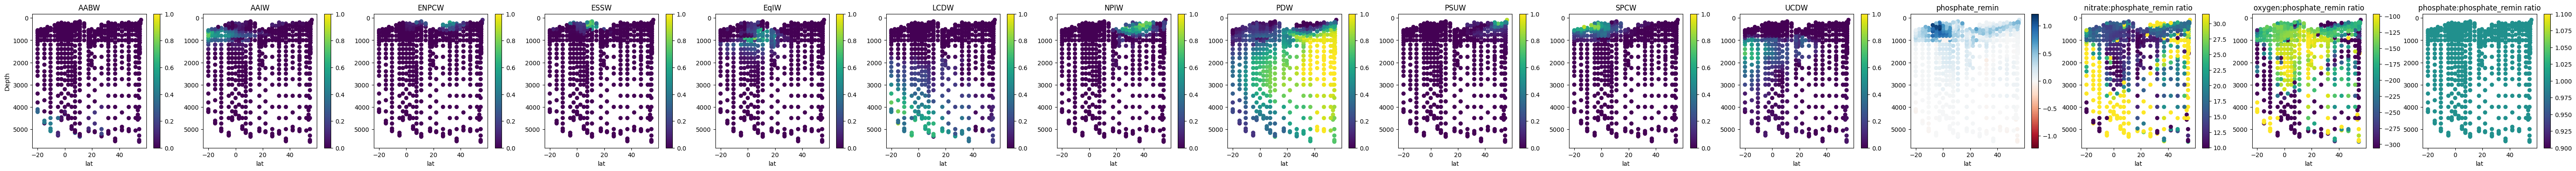

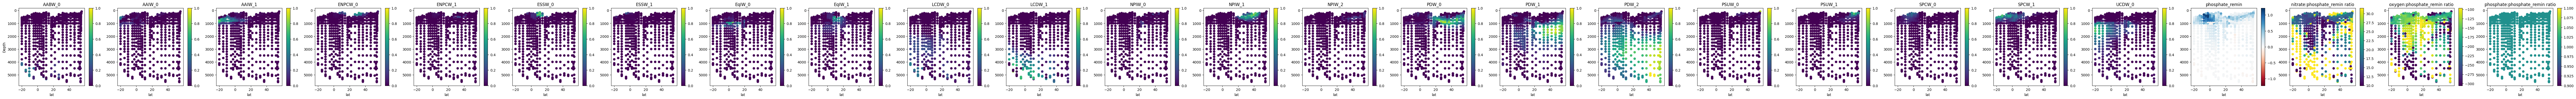

Plotting absolute residuals
Setting: flexiblereminratio_manyarchetypes


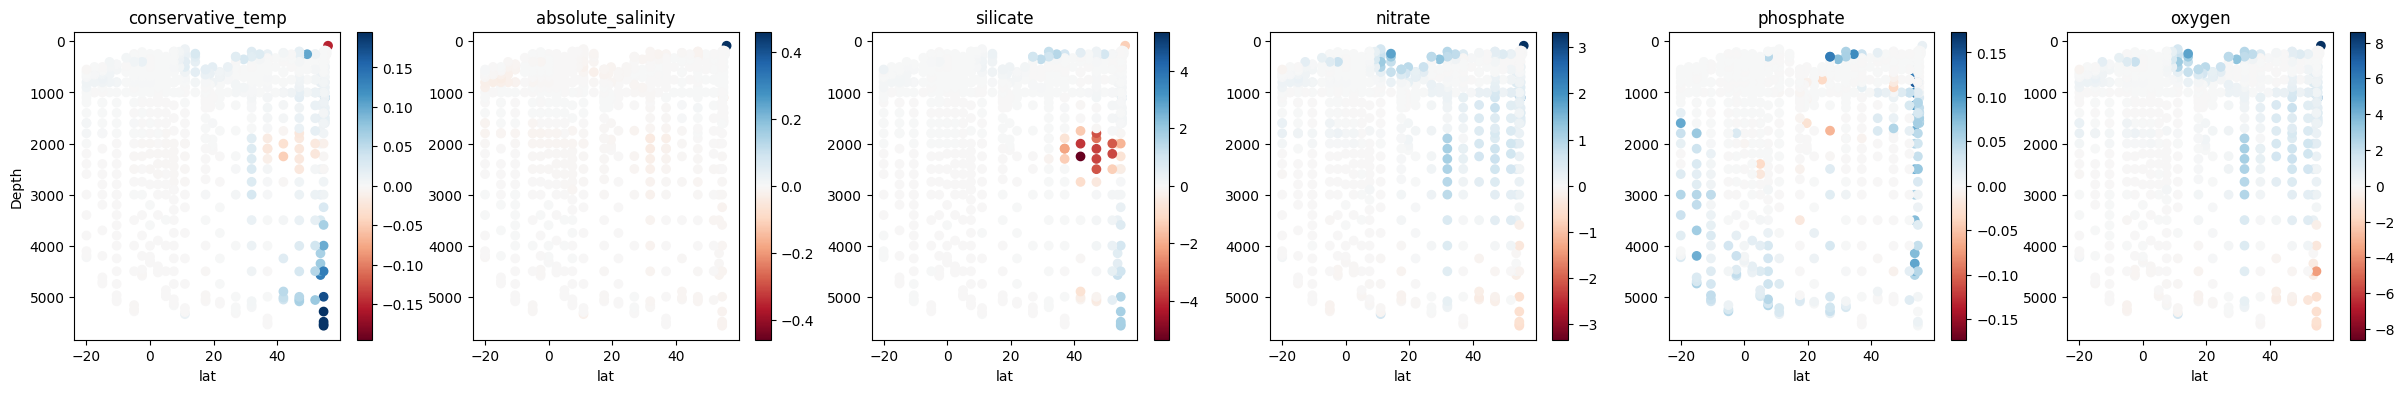

Plotting penalties
Setting: flexiblereminratio_manyarchetypes


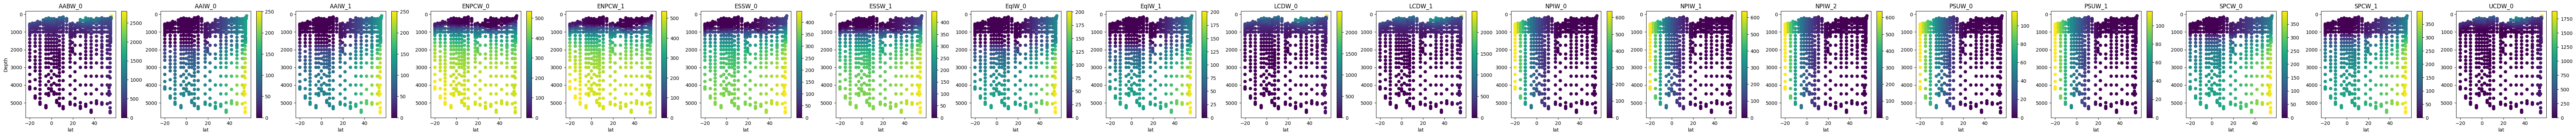

In [21]:
import numpy as np
from matplotlib import pyplot as plt
reload(pyompa)
from pyompa import (plot_ompasoln_endmember_fractions,                       
                    plot_ompasoln_residuals,                                 
                    plot_ompasoln_endmember_usagepenalties)


print("Plotting endmember fractions")
for setting in intermediateanddeep_settingtosoln:
    print("Setting:", setting)
    ompa_soln = intermediateanddeep_settingtosoln[setting]
    plot_ompasoln_endmember_fractions(ompa_soln=ompa_soln,
                                      xaxis_colname="lat",
                                      yaxis_colname="Depth",
                                      group_endmembers=True)
    plot_ompasoln_endmember_fractions(ompa_soln=ompa_soln,
                                      xaxis_colname="lat",
                                      yaxis_colname="Depth",
                                      group_endmembers=False)


print("Plotting absolute residuals")
for setting in intermediateanddeep_settingtosoln:
    print("Setting:", setting)
    ompa_soln = intermediateanddeep_settingtosoln[setting]
    plot_ompasoln_residuals(ompa_soln=ompa_soln,
                            xaxis_colname="lat",
                            yaxis_colname="Depth")
    
print("Plotting penalties")
for setting in intermediateanddeep_settingtosoln:
    print("Setting:", setting)
    ompa_soln = intermediateanddeep_settingtosoln[setting]
    plot_ompasoln_endmember_usagepenalties(ompa_soln=ompa_soln,
                            xaxis_colname="lat",
                            yaxis_colname="Depth")

In [22]:
INTERANDDEEP_SETTINGTOUSE = "flexiblereminratio_manyarchetypes"

### Intermediate and deep waters uncertainty analysis

In [25]:
#quantify variation in min/max for each endmember and the remineralization amount
from mpl_toolkits.axes_grid1 import make_axes_locatable
reload(pyompa)
from pyompa.util import collapse_endmembers_by_idxmapping, organize_converted_vars_by_groupname
from pyompa.plotting import plot_residuals, plot_endmember_fractions

soln = intermediateanddeep_settingtosoln[INTERANDDEEP_SETTINGTOUSE]
#soln = intermediateanddeep_settingtosoln["flexiblereminratio_onearchetype"]

#max_resids = np.array([0.01, 0.04, 4, 1, 0.15, 2])
max_resids = np.array([0.001, 0.004, 0.4, 0.1, 0.015, 0.2])

interanddeep_ambiguity_results_max = {}
interanddeep_ambiguity_results_min = {}

for endmemberoverallidx, (endmembername, endmember_idxs) in enumerate(soln.endmembername_to_indices.items()):
    if (True):#endmembername in ["ESSW"]):
        print("On",endmembername)
        maximizing_obj = np.zeros((len(soln.endmember_names) + soln.ompa_problem.num_converted_variables,))
        maximizing_obj[endmember_idxs] = -1
        
        ompasoln_max = pyompa.ompacore.OMPASoln.core_quantify_ambiguity_via_residual_limits(
                                      self=soln, obj_weights=maximizing_obj,
                                      max_resids=max_resids)
        interanddeep_ambiguity_results_max[endmembername] = ompasoln_max
        
        minimizing_obj = np.zeros((len(soln.endmember_names) + soln.ompa_problem.num_converted_variables,))
        minimizing_obj[endmember_idxs] = 1
        ompasoln_min = pyompa.ompacore.OMPASoln.core_quantify_ambiguity_via_residual_limits(
                                      self=soln, obj_weights=minimizing_obj, max_resids=max_resids)
        interanddeep_ambiguity_results_min[endmembername] = ompasoln_min
        

        """print("Original")
        plot_ompasoln_endmember_fractions(ompa_soln=soln,
                                      xaxis_colname="lat",
                                      yaxis_colname="Depth",
                                      group_endmembers=True)
                
        print("With min fractions")
        plot_ompasoln_endmember_fractions(ompa_soln=ompasoln_min,
                                      xaxis_colname="lat",
                                      yaxis_colname="Depth",
                                      group_endmembers=True)
        print("With max fractions")
        plot_ompasoln_endmember_fractions(ompa_soln=ompasoln_max,
                                      xaxis_colname="lat",
                                      yaxis_colname="Depth",
                                      group_endmembers=True)"""
        
        """print("original")
        fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(25,5))
        origscatter = ax[0].scatter(soln.obs_df["lat"], -soln.obs_df["Depth"],
                                    c=collapsed_fractions[:,endmemberoverallidx],
                                    vmin=0, vmax=1.0)
        divider = make_axes_locatable(ax[0])
        cax = divider.append_axes('right', size='5%', pad=0.05)
        plt.colorbar(origscatter, cax=cax)
        ax[0].set_title("Original")
        ax[0].set_ylabel("-Depth")

        lowerscatter = ax[1].scatter(soln.obs_df["lat"], -soln.obs_df["Depth"],
                       c=minwm, #- collapsed_fractions[:,endmemberoverallidx]
                       vmin=0, vmax=1.0)
        divider = make_axes_locatable(ax[1])
        cax = divider.append_axes('right', size='5%', pad=0.05)
        plt.colorbar(lowerscatter, cax=cax)
        ax[1].set_title("Lowerbound")

        upperscatter = ax[2].scatter(soln.obs_df["lat"], -soln.obs_df["Depth"],
                               c=-maxwm, #- collapsed_fractions[:,endmemberoverallidx]
                               vmin=0, vmax=1.0)
        divider = make_axes_locatable(ax[2])
        cax = divider.append_axes('right', size='5%', pad=0.05)
        plt.colorbar(upperscatter, cax=cax)
        ax[2].set_title("Upperbound")

        plt.show()"""

On AABW


TypeError: ignored

## Thermocline Analysis

In [26]:
#Thermocline files include endmembers in the range of potential density 21 to 27 
#conservative temeprature added in place of PO column
 
!wget https://github.com/nitrogenlab/GP15_watermassanalysis/raw/main/ENPCW.csv -O ENPCW.csv
!wget https://github.com/nitrogenlab/GP15_watermassanalysis/raw/main/SPCW.csv -O SPCW.csv
!wget https://github.com/nitrogenlab/GP15_watermassanalysis/raw/main/PSUW.csv -O PSUW.csv
!wget https://github.com/nitrogenlab/GP15_watermassanalysis/raw/main/ESSW.csv -O ESSW.csv
!wget https://github.com/nitrogenlab/GP15_watermassanalysis/raw/main/SPSTSW.csv -O SPSTSW.csv

--2021-12-12 05:21:47--  https://github.com/nitrogenlab/GP15_watermassanalysis/raw/main/ENPCW.csv
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/nitrogenlab/GP15_watermassanalysis/main/ENPCW.csv [following]
--2021-12-12 05:21:47--  https://raw.githubusercontent.com/nitrogenlab/GP15_watermassanalysis/main/ENPCW.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 61159 (60K) [text/plain]
Saving to: ‘ENPCW.csv’

ENPCW.csv           100%[===================>]  59.73K  --.-KB/s    in 0.003s  

2021-12-12 05:21:48 (17.5 MB/s) - ‘ENPCW.csv’ saved [61159/61159]

--2021-12-12 05:21:48--  https://github.

In [27]:
print("First ten rows")
!head "PSUW.csv"
print("last ten rows")
!tail "PSUW.csv"

First ten rows
sigma0,conservative_temp,absolute_salinity,nitrate,phosphate,oxygen,silicate
23.71,16.659886185030786,32.67347568128338,4.901395736243347,0.6188224611469815,258.40742286250804,4.298110841793359
23.720000000000002,16.60768238542432,32.672209014071655,4.91544654118366,0.6212312529374414,258.6411096694951,4.4039396523250165
23.73,16.555478868844716,32.67094255452511,4.929507083636,0.6236408857371811,258.8747556438241,4.509773097150904
23.740000000000002,16.503275868857816,32.669676464505834,4.943586548597847,0.6260521528359143,259.1083305424962,4.615615547611637
23.75,16.451073619029547,32.668410905875895,4.957694121066658,0.6284658475233508,259.34180412251226,4.72147137504768
23.76,16.39887236619977,32.66714604839704,4.97183897619652,0.6308827640078748,259.57514661577636,4.827344924186211
23.77,16.34667264821249,32.66588222681714,4.986029448720749,0.6333037678131084,259.8083401859028,4.933238307384969
23.78,16.294475403107356,32.664619995660196,5.000271874489124,0.63572988

Plotting for PSUW


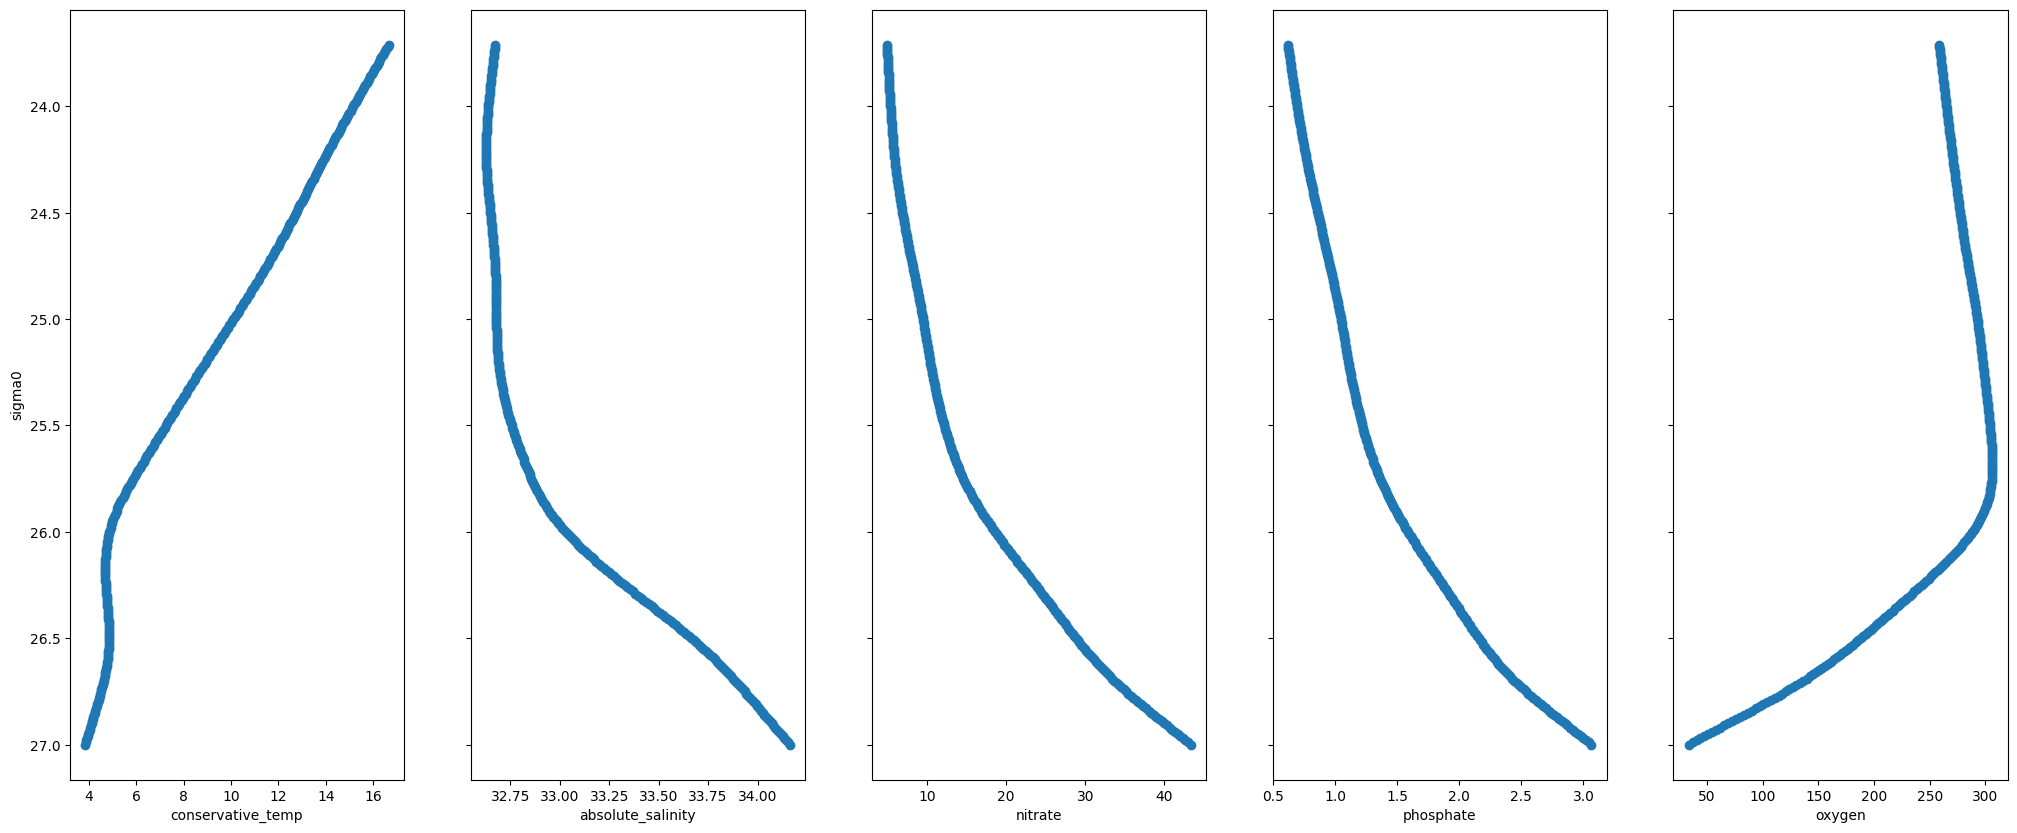

Plotting for ENPCW


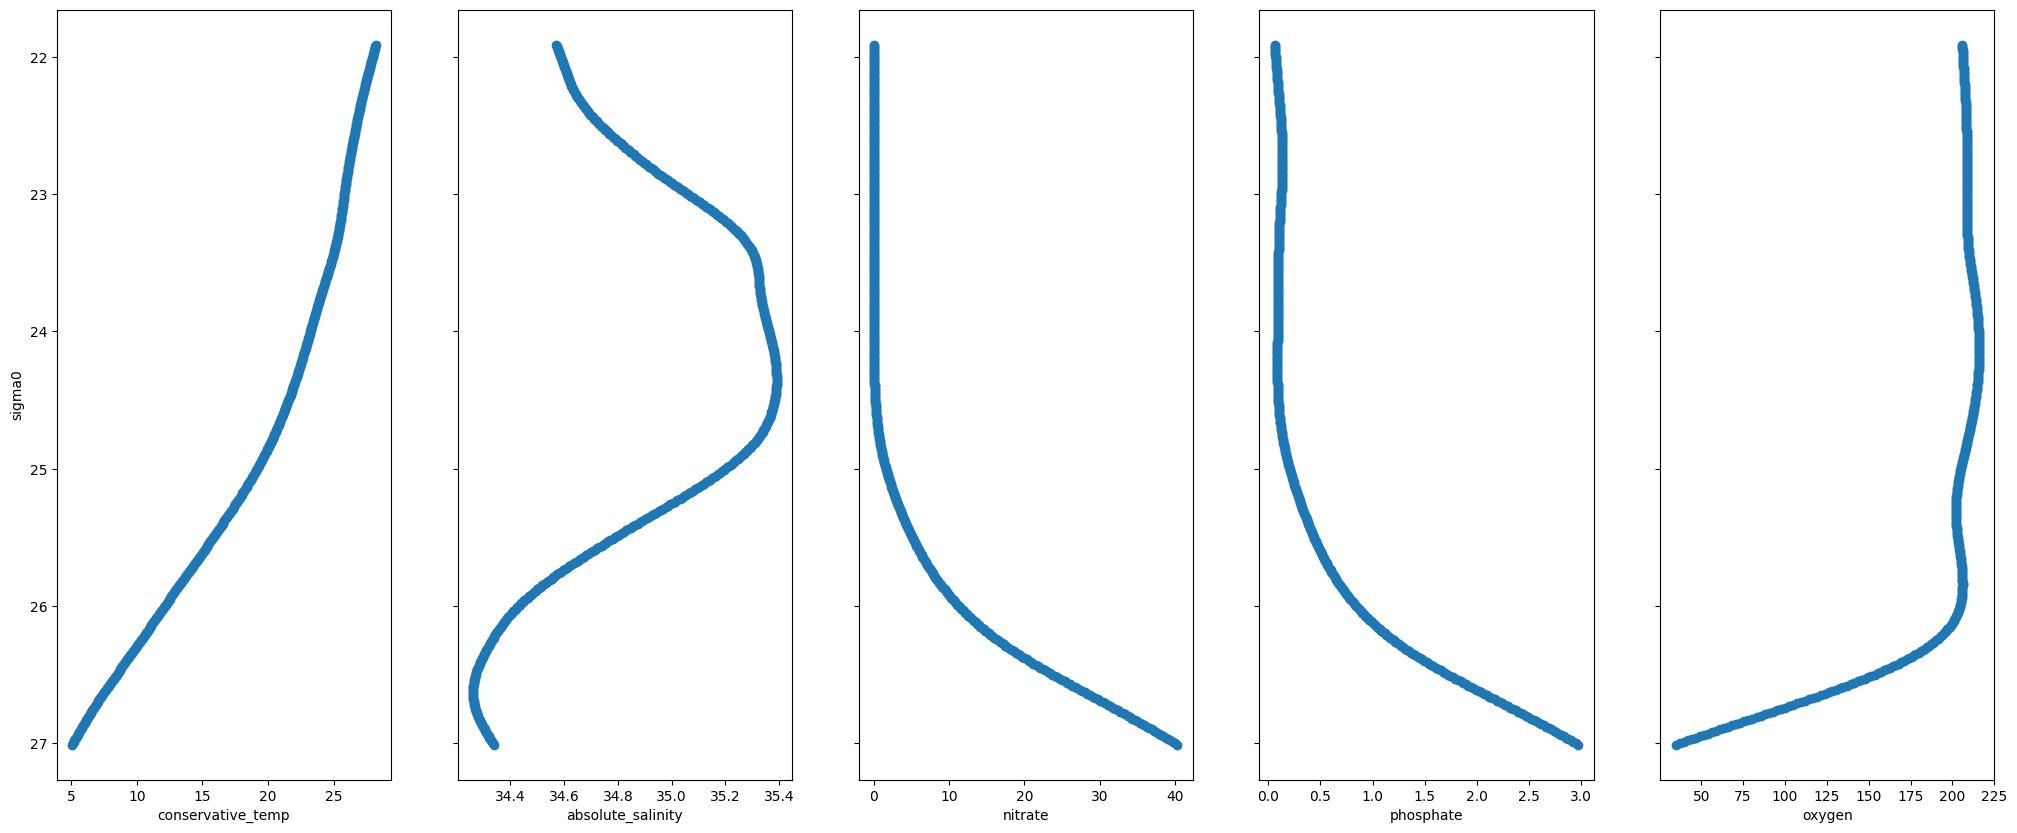

Plotting for ESSW


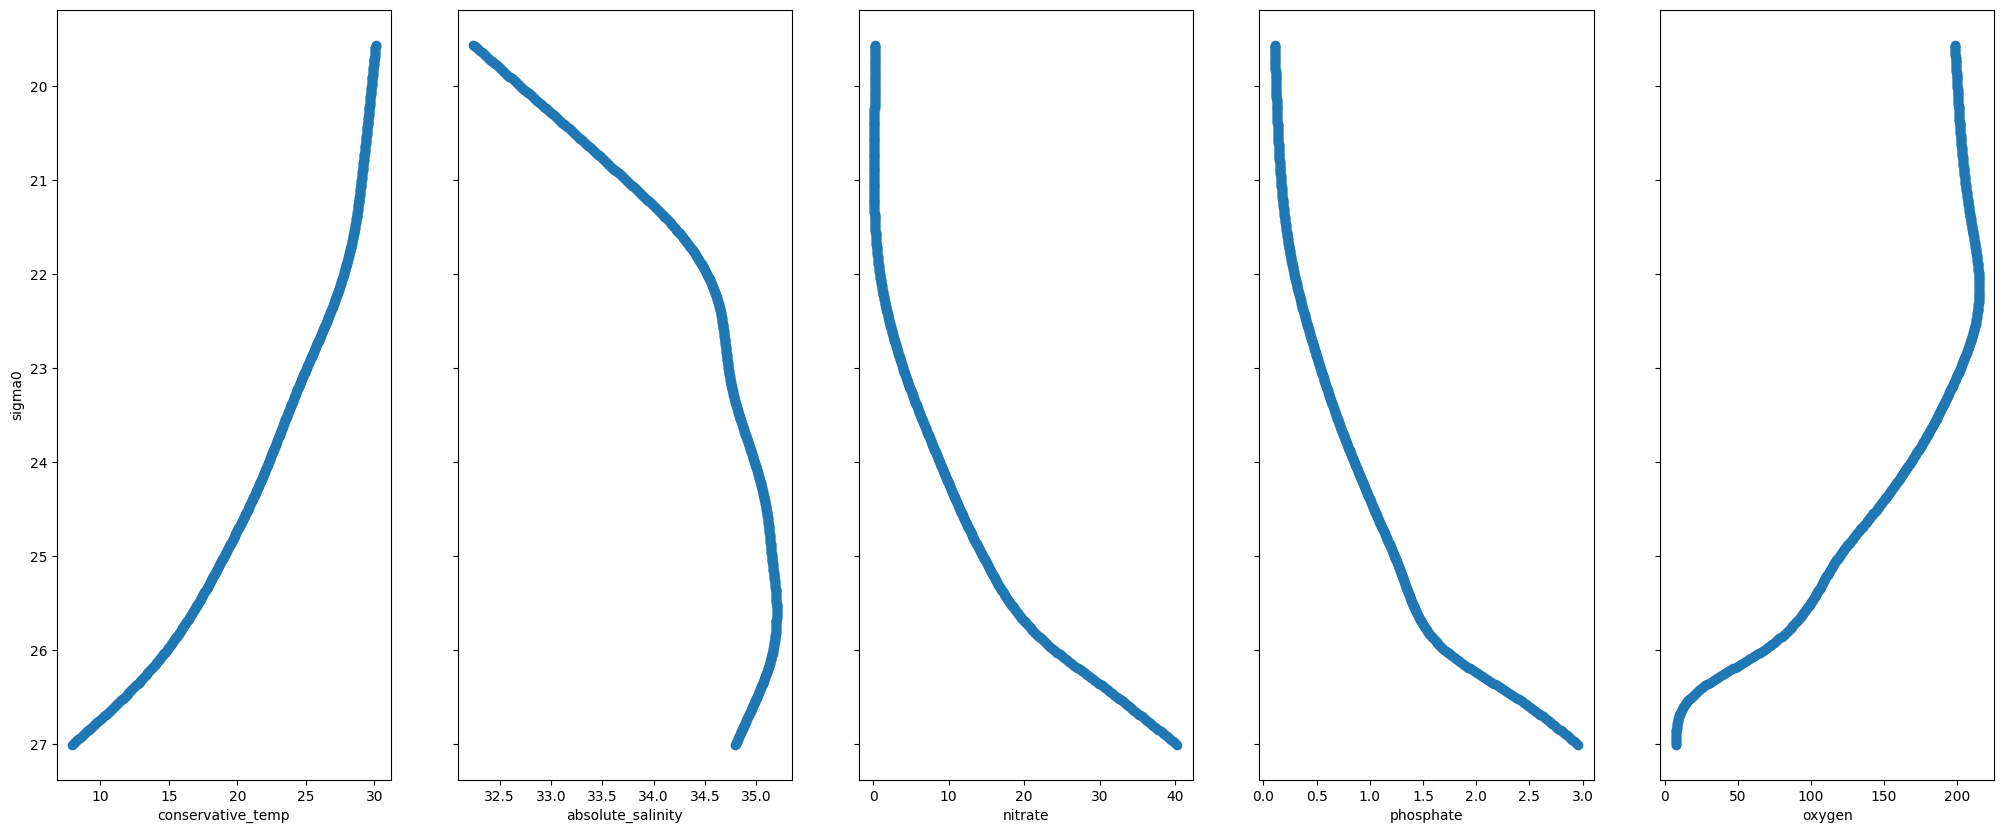

Plotting for SPCW


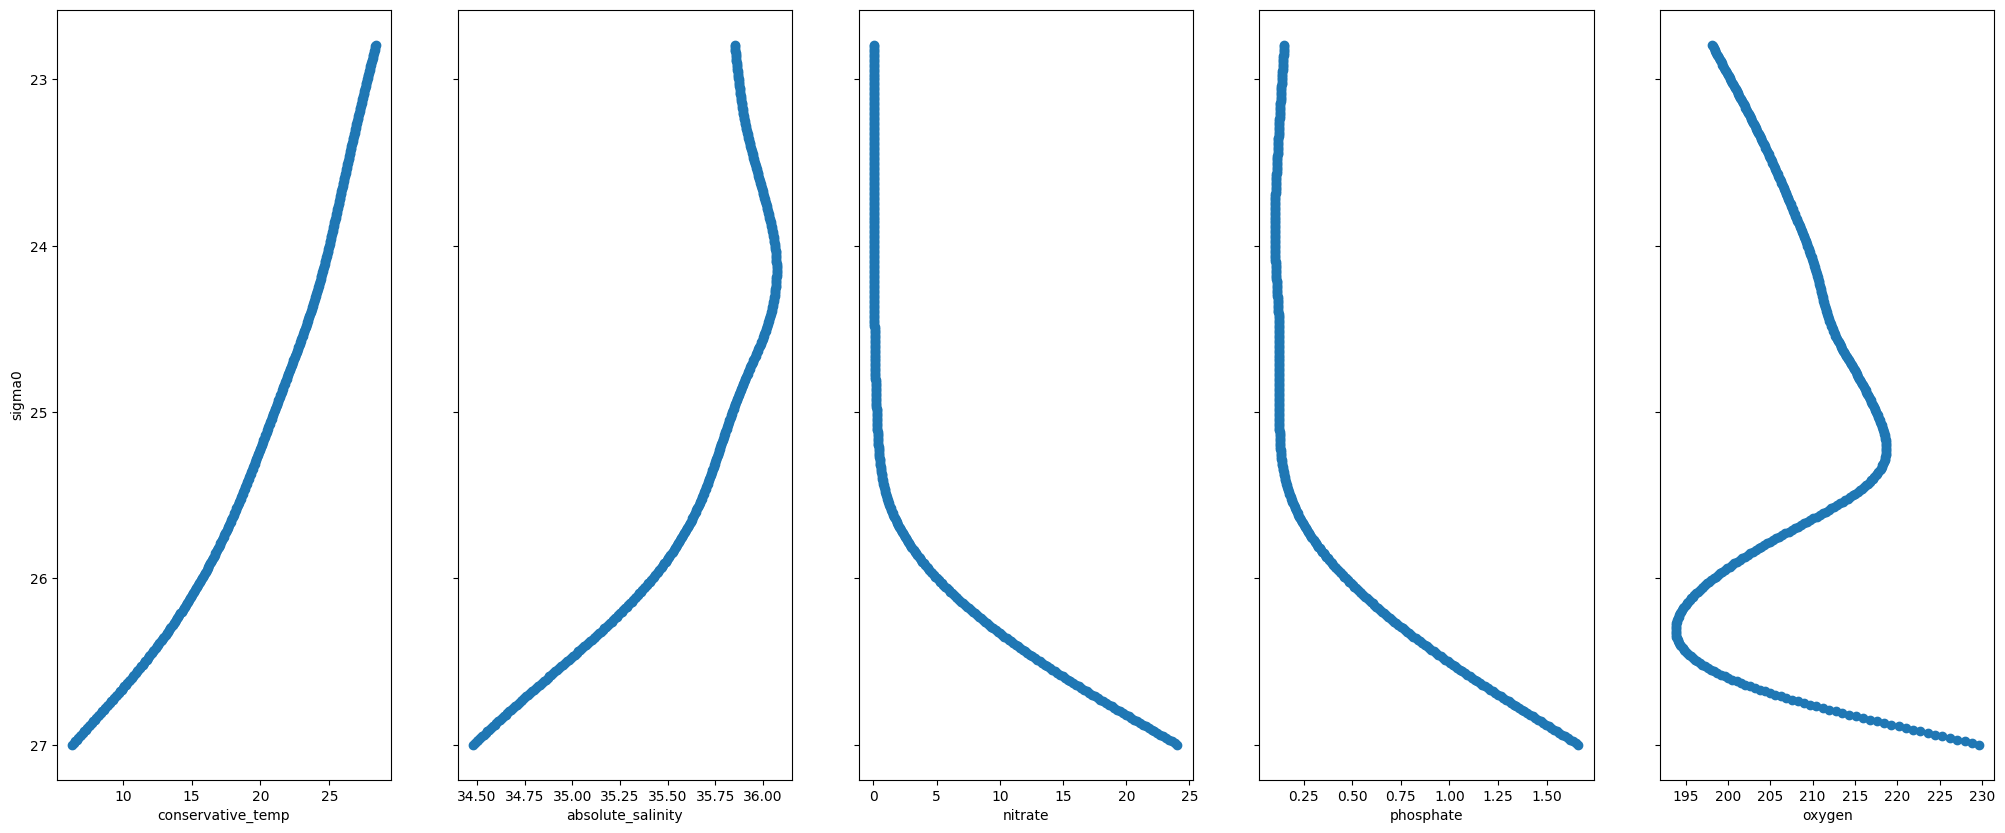

Plotting for SPSTSW


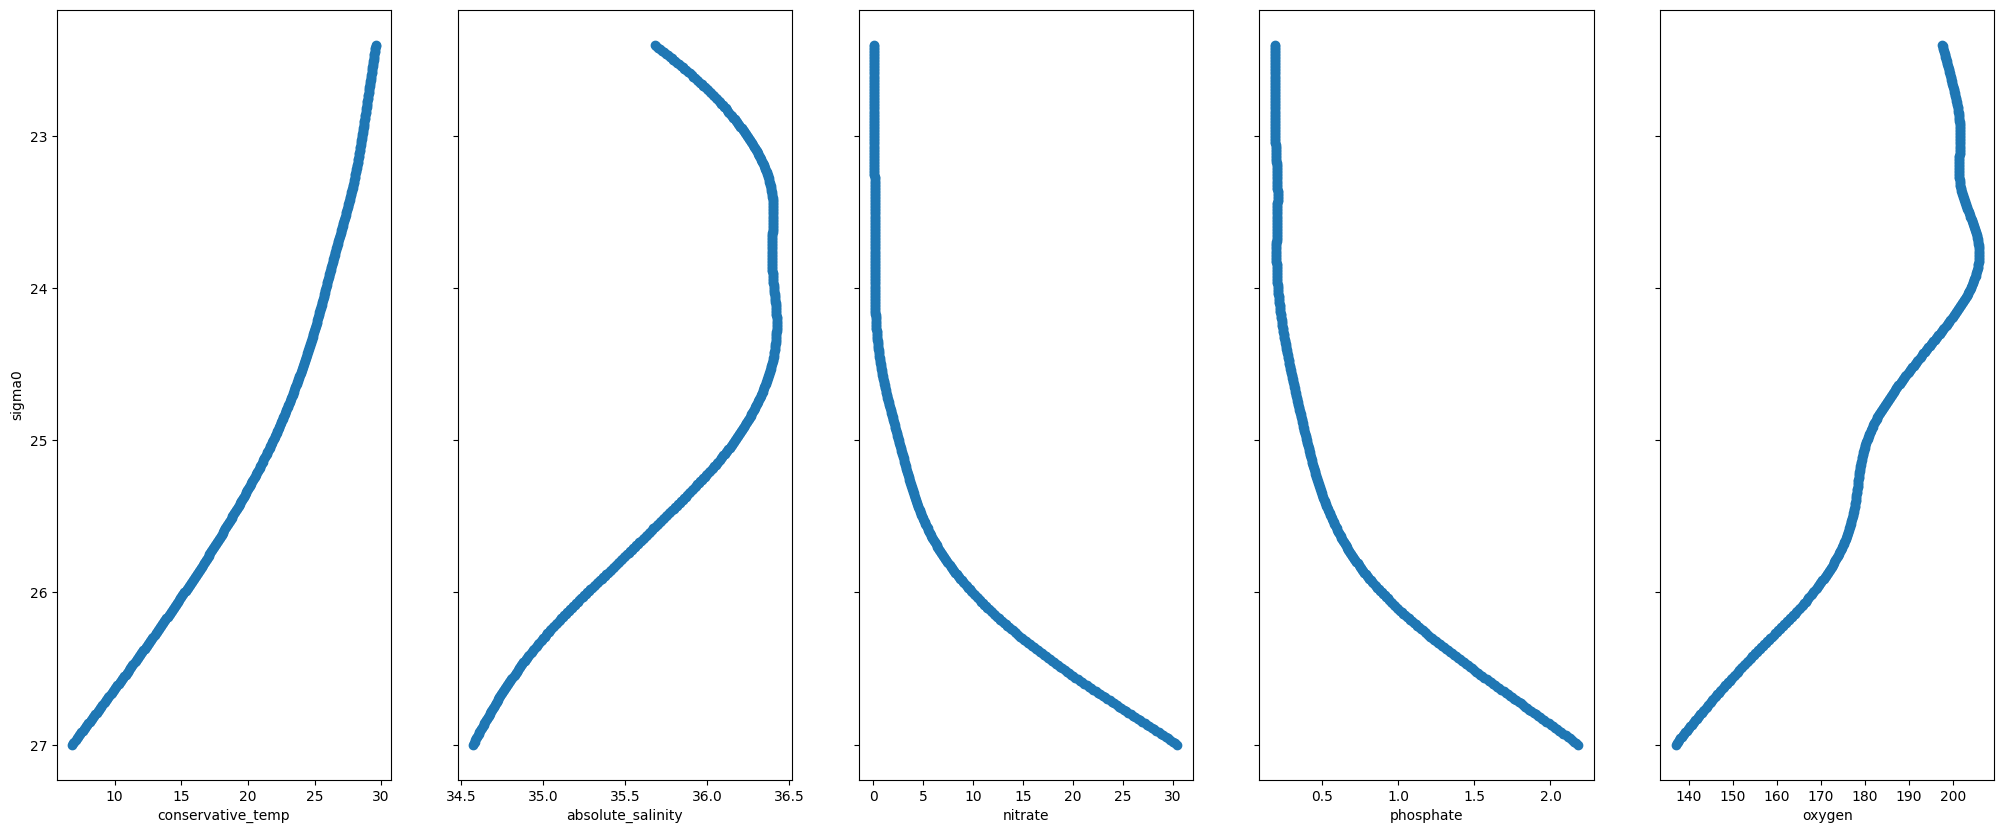

In [28]:
import pandas as pd
from matplotlib import pyplot as plt


def read_in_thermocline_endmemberdfs(endmemname_to_csv):
    #This function reads in the data frames for the thermocline end members
    #It takes endmemname_to_csv as input, which maps the thermocline
    # end member name (e.g. ENPCW) to the corresponding csv file.
    endmemname_to_df = {}
    #iterate through every endmemname in endmemname_to_csv
    #Order of thermocline endmember file columns: Sig0 pt SP O Si N P PO Pres spic0 vor NO Lat Lon T]);
    #e.g.
    header = ["c"+str(i) for i in range(1,17)] 
    header[0] = "sigma0" #potential density 
    header[1] = "potential_temp"
    header[2] = "practical_salinity"
    header[3] = "oxygen"
    header[4] = "silicate"
    header[5] = "nitrate"
    header[6] = "phosphate"
    header[7] = "CT" 
    header[8] = "CTD pressure"
    header[9] = "latitude"
    header[10] = "longitude"
    header[11] = "CTD temperature"

    TOPLOT = ["conservative_temp", "absolute_salinity",
              "nitrate", "phosphate", "oxygen"]

    #make sure header names are compatible
    # with those used in the prepare_endmember_df function defined earlier
    # for intermediate waters.
    for endmemname in endmemname_to_csv.keys():
        #get the csv file corresponding to the endmemname
        csv = endmemname_to_csv[endmemname]
        #read the csv file into a data frame df
        df = pd.read_csv(csv)
        augment_df_with_PO_NO_SiO(df)
        #Also add a column to the df that just has the end member name
        # repeated for each row. This will come in handy later when
        # pairing rows from different data frames
        #df["watermassname"] = endmemname
        #store df in endmemname_to_df with the key endmemname
        endmemname_to_df[endmemname] = df;

        fig, ax = plt.subplots(nrows=1, ncols=len(TOPLOT),
                         sharey=True,
                         figsize=(len(TOPLOT)*5, 10))
        for idx,feature_name in enumerate(TOPLOT):
          plt.sca(ax[idx])
          plt.xlabel(feature_name)
          plt.scatter(df[feature_name], df["sigma0"])
        
        plt.sca(ax[0])
        plt.ylabel("sigma0")
        plt.ylim(plt.ylim()[1], plt.ylim()[0])

        print("Plotting for "+endmemname)
        plt.show()

    return endmemname_to_df


#To read in thermocline files via a for loop, first create a dictionary that maps the
# end member name (e.g. PSUW) to the paths for the csv files that
# should be used
endmemname_to_csv = {
    "PSUW": "PSUW.csv",
    "ENPCW": "ENPCW.csv",
    "ESSW": "ESSW.csv",
    "SPCW": "SPCW.csv",
    "SPSTSW": "SPSTSW.csv",
}
#Then, call a function that will run a for loop to read in
# the data frames for the thermocline endmembers.
#The function will return a dictionary that maps the
# thermocline end member to the corresponding dataframe
endmemname_to_df = read_in_thermocline_endmemberdfs(endmemname_to_csv)

t_endmember_usagepenalty = {
   "PSUW": EndMemExpPenaltyFunc(
       spec={
           'lat': {'type':'other',"alpha":0.3, "beta":50, 'lowerbound':20}
           }),
   "ESSW": EndMemExpPenaltyFunc(
       spec={
           'lat': {'type':'latlon_default', 'upperbound':20}
           }),
   "ENPCW": EndMemExpPenaltyFunc(
       spec={
           'lat': {'type':'latlon_default', 'lowerbound':0}
           }),
   "SPCW": EndMemExpPenaltyFunc(
       spec={
           'lat': {'type':'other',"alpha":0.3, "beta":50, 'upperbound':5}
           }),
   "SPSTSW": EndMemExpPenaltyFunc(
       spec={
           'lat': {'type':'latlon_default', 'upperbound':0}
           }),
}

In [29]:
!pip uninstall -y pyompa
%cd /content/
!rm -rf pyompa
!git clone https://github.com/nitrogenlab/pyompa
%cd /content/pyompa
!git checkout dev
!git log -1
!pip install .
%cd /content/

%reload_ext autoreload
%autoreload 2
from importlib import reload
import pyompa
reload(pyompa)

Found existing installation: pyompa 0.4.0.0
Uninstalling pyompa-0.4.0.0:
  Successfully uninstalled pyompa-0.4.0.0
/content
Cloning into 'pyompa'...
remote: Enumerating objects: 1272, done.
remote: Counting objects: 100% (580/580), done.
remote: Compressing objects: 100% (384/384), done.
remote: Total 1272 (delta 410), reused 341 (delta 193), pack-reused 692
Receiving objects: 100% (1272/1272), 14.92 MiB | 19.84 MiB/s, done.
Resolving deltas: 100% (896/896), done.
/content/pyompa
Branch 'dev' set up to track remote branch 'dev' from 'origin'.
Switched to a new branch 'dev'
commit 96a9520fe0cf7ecad24b1d2ba69952d473ecfe26 (HEAD -> dev, origin/dev)
Author: Av Shrikumar <avanti.shrikumar@gmail.com>
Date:   Wed Dec 8 15:56:32 2021 -0800

    rolled back change
Processing /content/pyompa
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with

/content


<module 'pyompa' from '/usr/local/lib/python3.7/dist-packages/pyompa/__init__.py'>

In [30]:
reload(pyompa)
reload(pyompa.thermocline_array)
from pyompa import ThermoclineArrayOMPAProblem
from collections import OrderedDict

#Define thermocline
#By convention, constants are in all caps
#TC_UPPER_BOUND = 26.6
#TC_LOWER_BOUND = 25.5
TC_UPPER_BOUND = 27
TC_LOWER_BOUND = 22
TC_STEP = 0.01
#therm_endmem_to_use = ["PSUW","ENPCW","ESSW", "SPCW"] #thermocline water masses for analysis
# members to use in the analysis 
#gp15_thermocline = gp15_df[(gp15_df["sigma0"] >= TC_LOWER_BOUND)
#                            & (gp15_df["sigma0"] <= TC_UPPER_BOUND)]
gp15_thermocline =  gp15_df[gp15_df.apply(
        lambda x: (x['Depth'] > station_to_tcstartend[str(float(x['stnnbr']))]['depth_cutoffs'][0])
              and (x['Depth'] < station_to_tcstartend[str(float(x['stnnbr']))]['depth_cutoffs'][1]), axis=1)]
gp15_thermocline['tc'] = 1

rescale = 0.1 #for stabilizing the solver

thermocline_weighting = {
    "conservative_temp": rescale*200,
    "absolute_salinity": rescale*155,
    "silicate": rescale*5.0,
    "nitrate": rescale*50,
    "phosphate": rescale*50,
    "oxygen": rescale*10
}

settings_to_thermoclineomparesults = OrderedDict()

for (t_settingname, t_weighting) in [
          ('thermocline_weighting', thermocline_weighting),
          ]:
    print("setting name", t_settingname)
    settings_to_thermoclineomparesults[(t_settingname)] = ThermoclineArrayOMPAProblem(
         endmembername_to_usagepenaltyfunc=t_endmember_usagepenalty,
         stratification_col="sigma0",
         tc_lower_bound=TC_LOWER_BOUND,
         tc_upper_bound=TC_UPPER_BOUND,
         tc_step=TC_STEP,
         obs_df=gp15_thermocline,
         param_names=withconversion_paramnames,
         convertedparam_groups=convertedparamgroups_flexibleremineralization,
         param_weightings=t_weighting
     ).solve(endmemname_to_df=endmemname_to_df, max_iter=100000, verbose=False)


setting name thermocline_weighting
Heads up! You specified a tc lower bound of 22 but the observations df contains samples with a sigma0 as low as 21.447098641262073
Adding penalty for PSUW
Adding penalty for ESSW
Adding penalty for ENPCW
Adding penalty for SPCW
Adding penalty for SPSTSW
Endmember-idx mapping is
 OrderedDict([('ENPCW', [0]), ('ESSW', [1])])
---WARNING!---
You specified a usage penalty for PSUW but that endmember did not appear in the endmember data frame used here; endmembers are ['ENPCW', 'ESSW']
---WARNING!---
You specified a usage penalty for SPCW but that endmember did not appear in the endmember data frame used here; endmembers are ['ENPCW', 'ESSW']
---WARNING!---
You specified a usage penalty for SPSTSW but that endmember did not appear in the endmember data frame used here; endmembers are ['ENPCW', 'ESSW']
params to use: ['conservative_temp', 'absolute_salinity', 'silicate', 'nitrate', 'phosphate', 'oxygen']
param weighting: [20.  15.5  0.5  5.   5.   1. ]
Matri

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Streaming output truncated to the last 5000 lines.
Adding penalty for ESSW
Adding penalty for ENPCW
Adding penalty for SPCW
Adding penalty for SPSTSW
Endmember-idx mapping is
 OrderedDict([('ENPCW', [0]), ('ESSW', [1]), ('PSUW', [2]), ('SPCW', [3]), ('SPSTSW', [4])])
params to use: ['conservative_temp', 'absolute_salinity', 'silicate', 'nitrate', 'phosphate', 'oxygen']
param weighting: [20.  15.5  0.5  5.   5.   1. ]
Matrix A:
Trying convertedvariable sign constraint: [1 1]
On example 0 to 1 out of 1
status: optimal
optimal value 52.09188878703528
Original weighted sum squares: 52.00254870677206
Post fix weighted sum squared: 52.00254870698688
Trying convertedvariable sign constraint: [-1 -1]
On example 0 to 1 out of 1
status: optimal
optimal value 58.26569267373766
Original weighted sum squares: 57.586908272717324
Post fix weighted sum squared: 57.58690827279555
On example 0 to 1 out of 1
status: optimal
optimal value 52.09188878703528
Original weighted sum squares: 52.00254870677206


In [ ]:
plot_ompasoln_endmember_usagepenalties(settings_to_thermoclineomparesults['thermocline_weighting'], "lat", "Depth")

In [ ]:
reload(pyompa)
from pyompa import plot_ompasoln_endmember_fractions

print("Plotting endmember fractions")
for setting,thermocline_ompa_results in\
  settings_to_thermoclineomparesults.items():
    print(setting)
    plot_ompasoln_endmember_fractions(
      ompa_soln=thermocline_ompa_results, xaxis_colname="lat", yaxis_colname="Depth")

In [ ]:
from pyompa import plot_ompasoln_residuals

print("Plotting parameter residuals")
for setting,thermocline_ompa_results in\
    settings_to_thermoclineomparesults.items():
    print(setting)
    plot_ompasoln_residuals(ompa_soln=thermocline_ompa_results,
                            xaxis_colname="lat", yaxis_colname="Depth")


In [ ]:
THERMOCLINE_SETTINGTOUSE = "thermocline_weighting"

### Thermocline uncertainty analysis

In [ ]:
reload(pyompa.ompacore)
reload(pyompa.thermocline_array)

#uncertainty analysis for the thermocline
soln = settings_to_thermoclineomparesults[THERMOCLINE_SETTINGTOUSE]
max_resids = 10*np.array([0.001, 0.004, 0.4, 0.1, 0.015, 0.2])
#max_resids = np.array([0.001, 0.004, 0.4, 0.1, 0.015, 0.2])

thermocline_ambiguity_results_max = {}
thermocline_ambiguity_results_min = {}

for endmemberoverallidx, (endmembername, endmember_idxs) in enumerate(soln.endmembername_to_indices.items()):
    if (True):#endmembername in ["ESSW"]):
        print("On",endmembername)
        
        ompasoln_max = (pyompa.thermocline_array.ThermoclineArraySoln
                              .with_endmemtype_names_quant_ambig_via_res_lim(
                         self=soln, endmemtypename_to_weight={endmembername: -1},
                         max_resids=max_resids))
        thermocline_ambiguity_results_max[endmembername] = ompasoln_max

        ompasoln_min = (pyompa.thermocline_array.ThermoclineArraySoln
                              .with_endmemtype_names_quant_ambig_via_res_lim(
                         self=soln, endmemtypename_to_weight={endmembername: 1},
                         max_resids=max_resids))
        thermocline_ambiguity_results_min[endmembername] = ompasoln_min
                
        #print("Original")
        #plot_ompasoln_endmember_fractions(ompa_soln=soln,
        #                              xaxis_colname="lat",
        #                              yaxis_colname="Depth",
        #                              group_endmembers=True)
        
        print("With min fractions")
        plot_ompasoln_endmember_fractions(ompa_soln=ompasoln_min,
                                      xaxis_colname="lat",
                                      yaxis_colname="Depth",
                                      group_endmembers=True)
        print("With max fractions")
        plot_ompasoln_endmember_fractions(ompa_soln=ompasoln_max,
                                      xaxis_colname="lat",
                                      yaxis_colname="Depth",
                                      group_endmembers=True)
        
        #plot_residuals(param_residuals=new_resids_max, param_names=soln.param_names,
        #               xaxis_vals=soln.obs_df["lat"], xaxis_label="lat",
        #               yaxis_vals=soln.obs_df["Depth"], yaxis_label="Depth")
        #plot_residuals(param_residuals=new_resids_min, param_names=soln.param_names,
        #               xaxis_vals=soln.obs_df["lat"], xaxis_label="lat",
        #               yaxis_vals=soln.obs_df["Depth"], yaxis_label="Depth")

## Combining the results for intermediate & deep and the thermocline, plot and export

In [31]:
reload(pyompa)
from collections import OrderedDict

ORIG_COLS_TO_INCLUDE = ["lat", "lon", "Depth", "CTD pressure", "stnnbr", "geotrc_ID", "sigma0", "tc"]

base_intermediateanddeep =\
  intermediateanddeep_settingtosoln[INTERANDDEEP_SETTINGTOUSE]
base_thermocline =\
  settings_to_thermoclineomparesults[THERMOCLINE_SETTINGTOUSE]

base_combined = pyompa.ompacore.ExportToCsvMixin.merge(
  exptocsv1=base_intermediateanddeep, exptocsv2=base_thermocline)
base_combined.export_to_csv(
    csv_output_name="baseresults.csv",
    orig_cols_to_include=ORIG_COLS_TO_INCLUDE)

combined_ambiguity_results_max = OrderedDict()
combined_ambiguity_results_min = OrderedDict()

all_endmembertypes = sorted(set(
    list(interanddeep_ambiguity_results_max.keys())
    +list(thermocline_ambiguity_results_max.keys())))


for endmembername in all_endmembertypes:
  interanddeep_touse_max = base_intermediateanddeep
  interanddeep_touse_min = base_intermediateanddeep
  thermocline_touse_max = base_thermocline
  thermocline_touse_min = base_thermocline
  if endmembername in interanddeep_ambiguity_results_max:
    interanddeep_touse_max = interanddeep_ambiguity_results_max[endmembername]
    interanddeep_touse_min = interanddeep_ambiguity_results_min[endmembername]
  if endmembername in thermocline_ambiguity_results_max:
    thermocline_touse_max = thermocline_ambiguity_results_max[endmembername]
    thermocline_touse_min = thermocline_ambiguity_results_min[endmembername]
  
  combined_ambiguity_results_max[endmembername] =\
    pyompa.ompacore.ExportToCsvMixin.merge(
      exptocsv1=interanddeep_touse_max,
      exptocsv2=thermocline_touse_max)
  combined_ambiguity_results_max[endmembername].export_to_csv(
    csv_output_name="max_"+endmembername+"_results.csv",
    orig_cols_to_include=ORIG_COLS_TO_INCLUDE,
    #don't export the residuals cos they haven't been subject
    # to minimization beyond satisfying the constraints
    export_residuals=False)
  
  combined_ambiguity_results_min[endmembername] =\
    pyompa.ompacore.ExportToCsvMixin.merge(
      exptocsv1=interanddeep_touse_min,
      exptocsv2=thermocline_touse_min)
  combined_ambiguity_results_min[endmembername].export_to_csv(
    csv_output_name="min_"+endmembername+"_results.csv",
    orig_cols_to_include=ORIG_COLS_TO_INCLUDE,
    export_residuals=False)


#print(np.min([x['sig0_cutoffs'][1] for x in station_to_tcstartend.values()]))
#print(np.max([x['sig0_cutoffs'][1] for x in station_to_tcstartend.values()]))

NameError: ignored

Plotting (warning: this can make the notebook very large, sometimes too large to save)

In [ ]:
print("Base (original) plot")

plot_ompasoln_endmember_fractions(ompa_soln=base_combined,
                                xaxis_colname="lat",
                                yaxis_colname="Depth",
                                group_endmembers=True)
plot_ompasoln_residuals(ompa_soln=base_combined,
                        xaxis_colname="lat",
                        yaxis_colname="Depth")


In [ ]:
#Put in the endmember names in the list to plot the uncertainty for them
for endmembername in ["AABW", "AAIW", "NPIW", "EqIW", "UCDW", "LCDW","PDW","PSUW", 
                      "ENPCW", "ESSW", "SPCW", "SPSTSW"]:#all_endmembertypes:
  print("Uncertainty for endmembername:",endmembername)
  #print("Original")
  #plot_ompasoln_endmember_fractions(ompa_soln=base_combined,
  #                              xaxis_colname="lat",
  #                              yaxis_colname="Depth",
  #                              group_endmembers=True)
  print("With min fractions")
  plot_ompasoln_endmember_fractions(
      ompa_soln=combined_ambiguity_results_min[endmembername],
                                xaxis_colname="lat",
                                yaxis_colname="Depth",
                                group_endmembers=True)
  print("With max fractions")
  plot_ompasoln_endmember_fractions(
      ompa_soln=combined_ambiguity_results_max[endmembername],
                                xaxis_colname="lat",
                                yaxis_colname="Depth",
                                group_endmembers=True)

Download to hard drive

In [ ]:
from google.colab import files
import glob

!mkdir ompa_results
!mv *results.csv ompa_results
!zip -r ompa_results.zip ompa_results